In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df=pd.read_csv('final_data.csv')

In [3]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None) 

In [4]:
with open('traffic_model5.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

def prepare_features_for_prediction(source, destination, junction, vehicle_type, date):
   
    day_of_week = date.strftime('%A')
    
  
    route_data = df[(df['Source'] == source) & (df['Destination'] == destination) & (df['Junction'] == junction) & (df['Vehicle_type'] == vehicle_type)]
    
   
    if route_data.empty:
        print(f"No historical data for route from {source} to {destination} via {junction}. Using overall averages.")
        route_data = df.copy()
    
    number_of_signals = route_data['Number_of_signals'].mean()
    average_speed = route_data['Average_speed'].mean()
    vehicle_count = route_data['Vehicle_count'].mean()
    average_time_per_signal = route_data['Average_time_per_signal'].mean()
    
    
    features = {
        'Number_of_signals': number_of_signals,
        'Average_speed': average_speed,
        'Vehicle_count': vehicle_count,
        'Average_time_per_signal': average_time_per_signal,
        'Vehicle_type_' + vehicle_type: 1  # Vehicle type one-hot encoding
    }
    
    
    for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
        features[f'Day_of_week_{day}'] = 1 if day == day_of_week else 0
    
    
    features_df = pd.DataFrame([features])
    
   
    training_columns = loaded_model.feature_names_in_
    features_df = features_df.reindex(columns=training_columns, fill_value=0)
    
    return features_df

def predict_time_to_reach(features_df):
    predicted_time = loaded_model.predict(features_df)
    return predicted_time[0]

def estimate_other_metrics(source, destination, junction, vehicle_type, date):
   
    route_data = df[(df['Source'] == source) & (df['Destination'] == destination) & (df['Junction'] == junction) & (df['Vehicle_type'] == vehicle_type)]
    
    if route_data.empty:
        route_data = df.copy()
    
    avg_time_to_cross_junction = route_data['Average_time_to_cross_junction'].mean()
    num_signals = route_data['Number_of_signals'].mean()
    avg_time_per_signal = route_data['Average_time_per_signal'].mean()
    vehicle_count = route_data['Vehicle_count'].mean()
    average_speed = route_data['Average_speed'].mean()
    
   
    
    return {
        'Average_time_to_cross_junction': avg_time_to_cross_junction,
        'Number_of_signals': num_signals,
        'Average_time_per_signal': avg_time_per_signal,
        'Vehicle_count': vehicle_count,
        'Average_speed': average_speed
    }

In [5]:
def suggest_best_routes_future(source, destination, vehicle_type, date, top_n=5):
  
    possible_routes = df[(df['Source'] == source) & (df['Destination'] == destination)].copy()
    
   
    if possible_routes.empty:
        return f"No routes found from {source} to {destination}."
    
   
    possible_routes = possible_routes.drop_duplicates(subset=['Source', 'Destination', 'Junction'])
    
  
    route_evaluations = []
    
    for idx, route in possible_routes.iterrows():
        
        features_df = prepare_features_for_prediction(route['Source'], route['Destination'], route['Junction'], vehicle_type, date)
        
       
        predicted_time = predict_time_to_reach(features_df)
        
       
        other_metrics = estimate_other_metrics(route['Source'], route['Destination'], route['Junction'], vehicle_type, date)
       
        metrics_df = pd.DataFrame([{
            'Average_time_to_cross_junction': other_metrics['Average_time_to_cross_junction'],
            'Number_of_signals': other_metrics['Number_of_signals'],
            'Average_time_per_signal': other_metrics['Average_time_per_signal'],
            'Vehicle_count': other_metrics['Vehicle_count'],
            'Average_speed': other_metrics['Average_speed'],
            'Time_to_reach': predicted_time
        }])
        
      
        normalized_metrics = (metrics_df - metrics_df.min()) / (metrics_df.max() - metrics_df.min())
        
        
        score = (
            normalized_metrics['Average_time_to_cross_junction'] * 0.2 +
            normalized_metrics['Number_of_signals'] * 0.2 +
            normalized_metrics['Average_time_per_signal'] * 0.1 +
            normalized_metrics['Vehicle_count'] * 0.2 +
            (1 - normalized_metrics['Average_speed']) * 0.2 +  
            normalized_metrics['Time_to_reach'] * 0.1
        ).iloc[0]
        
        
        route_evaluations.append({
            'Source': route['Source'],
            'Destination': route['Destination'],
            'Junction': route['Junction'],  
            'Vehicle_type': vehicle_type,
            'Predicted_Time_to_Reach': predicted_time,
            'Average_time_to_cross_junction': other_metrics['Average_time_to_cross_junction'],
            'Number_of_signals': other_metrics['Number_of_signals'],
            'Average_time_per_signal': other_metrics['Average_time_per_signal'],
            'Vehicle_count': other_metrics['Vehicle_count'],
            'Average_speed': other_metrics['Average_speed'],
            'Score': score
        })
    
    routes_df = pd.DataFrame(route_evaluations)
    
    top_routes = routes_df.sort_values(by='Score').head(top_n)
    
    return top_routes

In [9]:
source_input = "Banashankari"
destination_input = "Shivajinagar"
vehicle_type_input = "Bike"  
date_input = datetime(2024, 10, 22) 


top_routes_future = suggest_best_routes_future(source_input, destination_input, vehicle_type_input, date_input, top_n=5)

top_routes_future.head()

No historical data for route from Banashankari to Shivajinagar via Kadugodi Junction. Using overall averages.
No historical data for route from Banashankari to Shivajinagar via K R Puram. Using overall averages.
No historical data for route from Banashankari to Shivajinagar via Bellanduru. Using overall averages.
No historical data for route from Banashankari to Shivajinagar via Majestic. Using overall averages.
No historical data for route from Banashankari to Shivajinagar via Trinity. Using overall averages.
No historical data for route from Banashankari to Shivajinagar via Adugodi. Using overall averages.
No historical data for route from Banashankari to Shivajinagar via Cubbon Park. Using overall averages.
No historical data for route from Banashankari to Shivajinagar via Silk Board. Using overall averages.
No historical data for route from Banashankari to Shivajinagar via Koramangala 1st block. Using overall averages.
No historical data for route from Banashankari to Shivajinagar 

,Source,Destination,Junction,Vehicle_type,Predicted_Time_to_Reach,Average_time_to_cross_junction,Number_of_signals,Average_time_per_signal,Vehicle_count,Average_speed,Score
0,Banashankari,Shivajinagar,Devanahalli,Bike,25.190000,33.666667,7.666667,1.666667,61.333333,57.0,NaN
1,Banashankari,Shivajinagar,MG Road,Bike,24.450000,48.000000,10.000000,2.000000,7.000000,41.0,NaN
2,Banashankari,Shivajinagar,Indiranagar,Bike,28.530000,51.000000,12.000000,1.000000,63.000000,60.0,NaN
3,Banashankari,Shivajinagar,Yeshwanthpur,Bike,24.655833,56.000000,12.000000,2.000000,32.000000,58.0,NaN
4,Banashankari,Shivajinagar,Church Street,Bike,52.480000,25.000000,14.000000,28.000000,51.000000,75.0,NaN


In [16]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'])


traffic_data_hourly = df.groupby(pd.Grouper(key='Date', freq='H')).agg({
    'Vehicle_count': 'mean', 
    'Average_time_to_cross_junction': 'mean', 
    'Number_of_signals': 'mean'
}).reset_index()

traffic_data_hourly.rename(columns={'Date': 'ds', 'Vehicle_count': 'y'}, inplace=True)

model = Prophet()


model.fit(traffic_data_hourly)


def plot_between_dates(start_date, end_date):
    future = model.make_future_dataframe(periods=30*24, freq='H')  
    

    forecast = model.predict(future)
    

    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    

    mask = (forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)
    filtered_forecast = forecast[mask]

    if filtered_forecast.empty:
        print(f"No data available between {start_date} and {end_date}")
        return


    plt.figure(figsize=(10, 6))
    plt.plot(filtered_forecast['ds'], filtered_forecast['yhat'], label='Predicted Vehicle Count', color='blue')
    plt.fill_between(filtered_forecast['ds'], filtered_forecast['yhat_lower'], filtered_forecast['yhat_upper'], color='lightblue', label='Confidence Interval')
    plt.title(f"Vehicle Count Forecast from {start_date.date()} to {end_date.date()}")
    plt.xlabel("Date")
    plt.ylabel("Vehicle Count")
    plt.legend()
    plt.grid(True)
    plt.show()



09:02:01 - cmdstanpy - INFO - Chain [1] start processing
09:02:01 - cmdstanpy - INFO - Chain [1] done processing


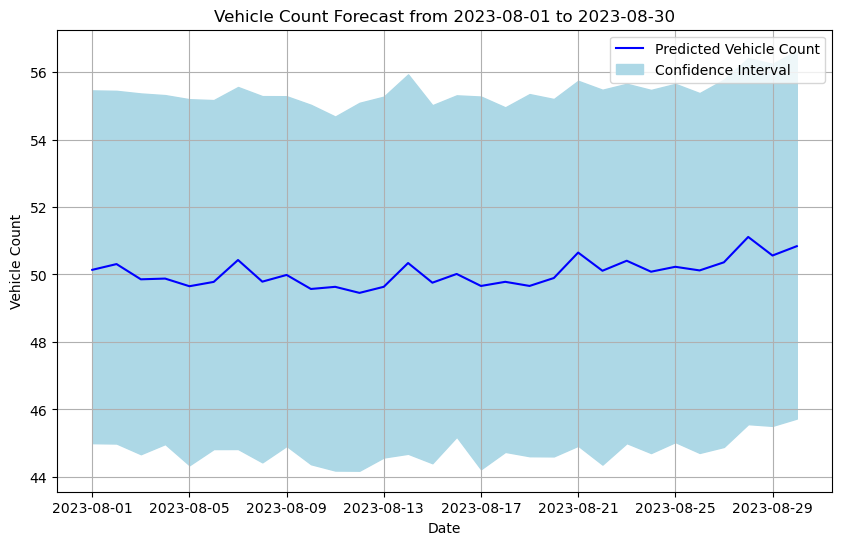

In [17]:
start_date = '2023-8-01'  
end_date = '2023-8-30'
plot_between_dates(start_date, end_date)


In [18]:
df.columns

Index(['Date', 'Day_of_week', 'Junction', 'Vehicle_type', 'Peak_time',
       'Average_time_to_cross_junction', 'Source', 'Destination',
       'Number_of_signals', 'Average_time_per_signal', 'Events_and_occasion',
       'Vehicle_count', 'Average_speed', 'Weather', 'Time_to_reach'],
      dtype='object')

In [19]:
df['Peak_time'].value_counts()

Peak_time
5 PM     20865
9 AM     20863
7 PM     20840
11 AM    20772
Name: count, dtype: int64